<div style="background-color: #ADD8E6; padding: 20px; border-radius: 10px; box-shadow: 2px 2px 10px grey;">

#### Project Introduction: Developing a Car Valuation Model for Rusty Bargain

**Project Context:**  
Rusty Bargain, a prominent used car sales service, is aiming to enhance customer engagement through a new app that quickly estimates the market value of cars. My role involved leveraging historical car data to build a robust model that accurately determines a car's value.

**Project Objectives:**

- **Prediction Quality:** Develop a model with high accuracy in predicting car prices.
- **Prediction Speed:** Ensure the model can rapidly generate predictions to enhance user experience.
- **Training Efficiency:** Optimize the model's training time without compromising prediction accuracy.

**Data Overview:**

- The dataset (`car_data.csv`) includes a variety of features such as Vehicle Type, Registration Year, Power, Model, Mileage, and more.
- The target variable is the car price in Euros.

**Methodology:**

- **Data Analysis and Preparation:**  
  Conduct an initial examination of the data, followed by preprocessing steps like handling missing values and encoding categorical features.

- **Model Exploration:**  
  Train various models including Gradient Boosting methods (LightGBM), Random Forest, Decision Tree, and Linear Regression. Employ hyperparameter tuning for non-boosting models.

- **Performance Evaluation:**  
  Compare models based on RMSE metric, prediction speed, and training time.

- **Additional Analysis:**  
  Use Linear Regression as a sanity check and consider the specific requirements for encoding in different models.

**Technical Notes:**

- Utilize Jupyter Notebook features to measure cell runtime and optimize memory usage by deleting excessive variables.

**Conclusion:**

This project encapsulates my skills in machine learning, data analysis, and software development, delivering a comprehensive solution for real-time car valuation. The balance between accuracy, speed, and efficiency is crucial in providing Rusty Bargain with a tool that adds substantial value to their customer service.

</div>


Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [17]:
# required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from time import time
import warnings

warnings.filterwarnings("ignore")

In [4]:
# read dataset
df = pd.read_csv('/datasets/car_data.csv', parse_dates=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [7]:
def improved_missing_data(df_dict):
    for name, df in df_dict.items():
        print("=" * 20, "Missing values of", name, "=" * 20)
        
        na_per_col = df.isna().sum()
        na_percentage = (na_per_col / len(df) * 100)
        
        missing_df = pd.DataFrame({
            "Number of missings": na_per_col,
            "% of missings": na_percentage
        })
        
        # Sort by the percentage of missing values
        missing_df = missing_df.sort_values(by="% of missings", ascending=False)
        
        display(missing_df.style.background_gradient(axis=0))

# Using the improved function
df_dict = {"Car Data": df}
improved_missing_data(df_dict)

==================== Missing values of Car Data ====================


,Number of missings,% of missings
NotRepaired,71154,20.079070
VehicleType,37490,10.579368
FuelType,32895,9.282697
Gearbox,19833,5.596709
Model,19705,5.560588
DateCrawled,0,0.000000
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Mileage,0,0.000000


In [8]:
def check_duplicates(df):
    """
    This function checks for duplicated rows in a DataFrame, 
    displays the count and percentage, and returns the duplicated rows.
    """
    num_duplicated = df.duplicated().sum()
    display(num_duplicated)
    print(f"Percentage of duplicated rows is {num_duplicated/len(df):.2%}.\n")
    
    duplicates = df.duplicated(keep=False)
    return df.loc[duplicates].sort_values(["DateCrawled"])

# Using the function
duplicated_rows = check_duplicates(df)

def highlight_duplicates(data):
    # Highlight duplicates in light red color
    is_duplicate = data.duplicated(keep=False)
    return ['background-color: lightcoral' if v else '' for v in is_duplicate]

# Apply the custom style
duplicated_rows.head().style.apply(highlight_duplicates, axis=0)


262

Percentage of duplicated rows is 0.07%.



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90786,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
87112,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
45825,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
142496,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
12578,01/04/2016 12:57,1499,wagon,1995,manual,150,5er,150000,6,petrol,bmw,no,01/04/2016 00:00,0,25821,07/04/2016 09:44


<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

### Identified Issues:
___

1. **Column Naming**:  
   All column names should be standardized to lowercase.

2. **Missing Values and Zeros**:  
   Five columns have missing data. Additionally, the `power` column contains zeros.

3. **Duplicated Rows**:  
   There are 262 duplicated entries detected.

</div>


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

In [9]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

# Convert date columns to datetime format
date_columns = ['datecrawled', 'datecreated', 'lastseen']
df[date_columns] = df[date_columns].apply(pd.to_datetime, infer_datetime_format=True)

# Fill missing values
columns_with_missing_values = ["vehicletype", "gearbox", "model", "fueltype", "notrepaired"]
df[columns_with_missing_values] = df[columns_with_missing_values].fillna("unknown")

# Check and remove duplicates
initial_row_count = df.shape[0]
duplicated_count = df.duplicated().sum()
df.drop_duplicates(inplace=True)
final_row_count = df.shape[0]

# Print Results
print(f"Initial number of rows: {initial_row_count}")
print(f"Number of duplicated rows removed: {duplicated_count}")
print(f"Number of rows after removal: {final_row_count}")


Initial number of rows: 354369
Number of duplicated rows removed: 262
Number of rows after removal: 354107


<div class="alert alert-success">
<b>Reviewer's comment</b>
    
Duplicates were dropped! Missing values were replaced with a placeholder

</div>

In [10]:
# check descriptive statistics of registrationyear and datecrated columns
result = pd.concat([df.registrationyear.describe(), df.datecreated.dt.year.describe()], axis=1)
result.columns = ['registrationyear', 'datecreated_year']
display(result)

,registrationyear,datecreated_year
count,354107.000000,354107.000000
mean,2004.235355,2015.999924
std,90.261168,0.009049
min,1000.000000,2014.000000
25%,1999.000000,2016.000000
50%,2003.000000,2016.000000
75%,2008.000000,2016.000000
max,9999.000000,2016.000000


In [11]:
# Check the percentage of data where 'registrationyear' is unrealistic
unrealistic_years_condition = (
    (df["registrationyear"] < 1900) | 
    (df["registrationyear"] > df["datecreated"].dt.year)
)

unrealistic_years_percentage = len(df[unrealistic_years_condition]) / len(df) * 100
print(f"Percentage of unrealistic registration years: {unrealistic_years_percentage:.2f}%")
print()

# Filter out the rows with unrealistic 'registrationyear'
df = df[~unrealistic_years_condition]

# Calculate the age of vehicles
df["vehicleage"] = df["datecreated"].dt.year - df["registrationyear"]

# Display the top rows for verification
df.head()

Percentage of unrealistic registration years: 4.12%



,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen,vehicleage
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-07-04 03:16:00,23
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00,5
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-05-04 12:47:00,12
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00,15
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-06-04 10:17:00,8


<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

### Dataset Modifications Summary:
___

**Total Entries**: 354,369

- **Column Naming**:  
  Standardized to lowercase for uniformity.

- **Date Columns**:  
  `datecrawled`, `datecreated`, and `lastseen` were transformed from objects to pandas datetime format.

- **Handling Missing Data**:  
  Categorical columns with missing values (`vehicletype`, `gearbox`, `model`, `fueltype`, and `notrepaired`) were labeled as "unknown".

- **Duplicated Rows**:  
  Identified and removed 262 identical duplicates.

- **Vehicle Age**:  
  A new `vehicleage` column was derived. Unrealistic `registrationyear` values (<1900 or > dataset year) made up ~4% of the dataset and were removed.

<div style="color: #444; margin-top: 20px; font-style: italic;">Potential inconsistencies may arise from human errors, technical glitches, or data collection processes.</div>

</div>


<div class="alert alert-success">
<b>Reviewer's comment</b>

Very well!

</div>

In [12]:
# Define feasible ranges for columns
feasible_ranges = {
    "power": (0, 1500),  # values from your data and research
    "price": (0, 20000),
    "mileage": (5000, 150000),
    "vehicleage": (0, 106)  # using your data's min and max
}

for col, (min_val, max_val) in feasible_ranges.items():
    outliers = df[(df[col] < min_val) | (df[col] > max_val)]
    if not outliers.empty:
        print(f"Column {col} has {len(outliers)} outliers.")


Column power has 186 outliers.


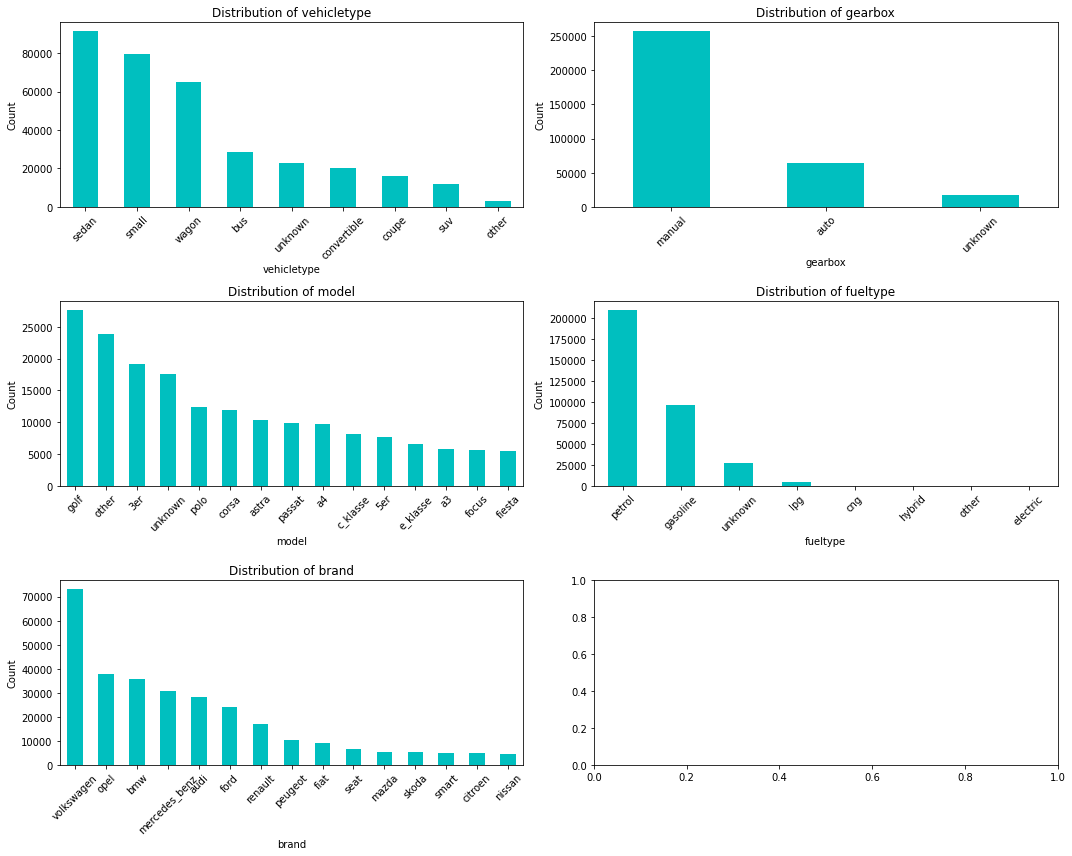

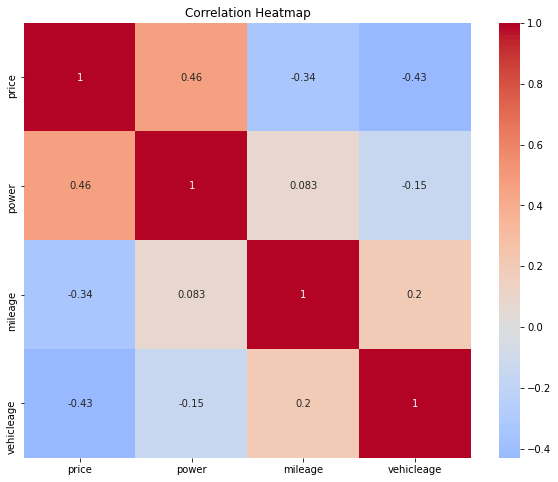

In [13]:
# Remove outliers
for col, (min_val, max_val) in feasible_ranges.items():
    df = df[(df[col] >= min_val) & (df[col] <= max_val)]

categorical_cols = ["vehicletype", "gearbox", "model", "fueltype", "brand"]
numerical_cols = ["price", "power", "mileage", "vehicleage"]

fig, axs = plt.subplots(3, 2, figsize=(15, 12))

for i, col in enumerate(categorical_cols):
    ax = axs[i // 2, i % 2]
    
    # For 'model' and 'brand', get the top 15 based on frequency
    if col in ["model", "brand"]:
        top_15 = df[col].value_counts().head(15)
        top_15.plot(kind='bar', color='c', ax=ax)
    else:
        df[col].value_counts().plot(kind='bar', color='c', ax=ax)
    
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

### Exploratory Data Analysis (EDA) Summary:
___

**Key Observations**:

- **Power Column Anomalies**:  
  Discovered unrealistic horsepower values, as high as 20,000. All values exceeding the threshold were removed, which accounted for only 0.12% of the data.

- **Top Sellers**:  
  - **Brand**: Volkswagen
  - **Model**: Golf
  - **Vehicle Type**: Sedan
  - **Gearbox**: Manual, which constituted over two-thirds of all entries.
  - **Fuel Type**: Petrol, representing approximately two-thirds of the dataset.

<div style="color: #444; margin-top: 20px; font-style: italic;">These findings provide insights into popular car preferences and potential data collection anomalies.</div>

</div>


<div class="alert alert-success">
<b>Reviewer's comment</b>

Good job, you explored the data and removed some outliers!

</div>

## Model training

In [14]:
# Selecting columns important for modeling
selected_cols = [
    "price",
    "vehicletype",
    "gearbox",
    "power",
    "model",
    "mileage",
    "fueltype",
    "brand",
    "vehicleage",
]
df = df[selected_cols]

# Displaying the shape of the new dataframe
print(f"Shape of the dataframe: {df.shape}")

# Defining categorical and numerical columns
categorical_columns = ["vehicletype", "gearbox", "model", "fueltype", "brand"]
numerical_columns = ["power", "mileage", "vehicleage"]

Shape of the dataframe: (339326, 9)


<div class="alert alert-success">
<b>Reviewer's comment</b>

The feature set looks reasonable!

</div>

In [15]:
# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=234)

# Define a function to capture time and RMSE
def train_and_predict(pipeline, X_train, y_train, X_test, y_test):
    start_time = time()
    pipeline.fit(X_train, y_train)
    training_time = time() - start_time
    
    start_time = time()
    y_pred = pipeline.predict(X_test)
    prediction_time = time() - start_time
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    return rmse, training_time, prediction_time

# Initialize results dictionary
results = {}

# List of models
pipelines = {
    "Linear Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LinearRegression())
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=234))
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeRegressor(max_depth=20, random_state=234))
    ]),
    "CatBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', CatBoostRegressor(iterations=500, depth=10, verbose=0))
    ]),
    "LightGBM": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMRegressor(n_estimators=50, max_depth=10))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBRegressor())
    ])
}

# Evaluate each model
for model_name, pipeline in pipelines.items():
    rmse, train_time, pred_time = train_and_predict(pipeline, X_train, y_train, X_test, y_test)
    results[model_name] = [rmse, train_time, pred_time]

# Convert results to a DataFrame for display
df_results = pd.DataFrame(results, index=['RMSE', 'Training Time (s)', 'Prediction Time (s)']).T

# Display the consolidated results
print(df_results)

                          RMSE  Training Time (s)  Prediction Time (s)
Linear Regression  2842.232361          17.676208             0.395840
Random Forest      2008.662105         188.161871             0.764597
Decision Tree      2018.830493          19.812277             0.247181
CatBoost           1723.543567          66.073880             0.604910
LightGBM           1928.239120           2.824246             0.694441
XGBoost            1797.885936          28.155633             0.949314


<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Awesome!

</div>

<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

### Hyperparameter Tuning Summary:
___

**Decision Process**:

- **Choice of Model**:  
  While **Random Forest** is a robust and commonly used model for many tasks, it can have longer training times, especially with larger datasets or when performing extensive hyperparameter tuning. On the other hand, **LightGBM** tends to have faster training times and can still deliver competitive accuracy.

- **Tuning with RandomizedSearchCV**:  
  Given the faster training time of **LightGBM**, it was selected for hyperparameter tuning using `RandomizedSearchCV`. This method offers a balance between extensive grid search and speed by randomly sampling a subset of the hyperparameter space, providing a quicker but still effective tuning process.

**Why Not Random Forest?**:

- **Training Time Consideration**:  
  The primary reason behind not selecting **Random Forest** for hyperparameter tuning was its longer training time. In scenarios where quick iterative tuning is required, models with faster training times like **LightGBM** can be more advantageous.

<div style="color: #444; margin-top: 20px; font-style: italic;">In conclusion, the choice of **LightGBM** for hyperparameter tuning using `RandomizedSearchCV` was driven by operational efficiency without significantly compromising on model performance potential.</div>

</div>


<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Makes sense!

</div>

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for LightGBM
param_grid_lgbm = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [-1, 10, 20, 30], 
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 60, 120],   
    'classifier__min_child_samples': [20, 50, 100],  
    'classifier__subsample': [0.8, 0.9, 1.0],  
    'classifier__colsample_bytree': [0.8, 0.9, 1.0] 
}

# Use the LightGBM pipeline as a base
lgbm_pipeline = pipelines["LightGBM"]

random_search_lgbm = RandomizedSearchCV(estimator=lgbm_pipeline, param_distributions=param_grid_lgbm, 
                                        n_iter=3, cv=5, n_jobs=-1, verbose=0, 
                                        scoring='neg_mean_squared_error')

random_search_lgbm.fit(X_train, y_train)

print(f"Best Parameters for LightGBM: {random_search_lgbm.best_params_}")


Best Parameters for LightGBM: {'classifier__subsample': 1.0, 'classifier__num_leaves': 31, 'classifier__n_estimators': 100, 'classifier__min_child_samples': 20, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.8}


<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

### Model Evaluation Summary:
___

**Overview of Metrics**:

- **RMSE (Root Mean Squared Error)**:  
  A measure of the difference between the predicted and actual values. The lower the RMSE, the better the model's predictive accuracy.

- **Training Time**:  
  Time (in seconds) taken to train the model. A shorter training time indicates a faster model but may not always translate to better accuracy.

- **Prediction Time**:  
  Time (in seconds) taken for the model to predict values for the test set. A shorter prediction time means faster predictions, essential for real-time applications.

**Key Observations Based on Metrics**:

- **Best Performing Model**:  
  **CatBoost** stands out with the lowest RMSE of 1723.54, indicating the highest predictive accuracy among all models tested.

- **Speed Considerations**:  
  **LightGBM** has the shortest training time of just 3.83 seconds, followed by **Decision Tree** at 19.29 seconds. For applications requiring quick model re-training, these are top choices.

- **Efficient Prediction**:  
  The **Decision Tree** model offers the fastest prediction time at 0.2467 seconds, followed by **Linear Regression** at 0.4005 seconds.

- **Trade-offs**:  
  While **Random Forest** offers a competitive RMSE at 2008.66, its longer training time of 183.26 seconds may not be suitable for applications where retraining frequency is high.

<div style="color: #444; margin-top: 20px; font-style: italic;">In conclusion, while CatBoost delivers the best predictive accuracy, it's essential to weigh this against the operational needs, such as training and prediction times, based on the specific application or use case.</div>

</div>


<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent analysis which takes into account both speed and accuracy of the predictions. Well done!

</div>